### Preparar dataset


In [428]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

In [429]:
# Leer el archivo de texto
df = pd.read_csv('./Data/data.txt', sep=' ', header=None)
df.columns = ['ID', 'Background_tissue', 'Class', 'Severity', 'Abnormality_X', 'Abnormality_Y', 'Radius']

print(df)

         ID Background_tissue Class Severity Abnormality_X Abnormality_Y  \
0    mdb001                 G  CIRC        B           535           425   
1    mdb002                 G  CIRC        B           522           280   
2    mdb003                 D  NORM      NaN           NaN           NaN   
3    mdb004                 D  NORM      NaN           NaN           NaN   
4    mdb005                 F  CIRC        B           477           133   
..      ...               ...   ...      ...           ...           ...   
325  mdb318                 D  NORM      NaN           NaN           NaN   
326  mdb319                 D  NORM      NaN           NaN           NaN   
327  mdb320                 D  NORM      NaN           NaN           NaN   
328  mdb321                 D  NORM      NaN           NaN           NaN   
329  mdb322                 D  NORM      NaN           NaN           NaN   

     Radius  
0     197.0  
1      69.0  
2       NaN  
3       NaN  
4      30.0  
.. 

In [430]:
import os
import pandas as pd

# Ruta de la carpeta principal (ahora sin subcarpetas)
ruta_carpeta_principal = 'outputs'

# Lista para almacenar las rutas de las imágenes
rutas_imagenes_hr = []

# Recorrer solo los archivos directamente en la carpeta
for archivo in os.listdir(ruta_carpeta_principal):
    if archivo.endswith('_SR.png'):
        ruta_completa = os.path.join(ruta_carpeta_principal, archivo)
        rutas_imagenes_hr.append(ruta_completa)

# Crear DataFrame
df_imagenes_hr = pd.DataFrame({'ruta_imagen': rutas_imagenes_hr})
print(df_imagenes_hr)


               ruta_imagen
0    outputs/mdb266_SR.png
1    outputs/mdb278_SR.png
2    outputs/mdb305_SR.png
3    outputs/mdb205_SR.png
4    outputs/mdb274_SR.png
..                     ...
317  outputs/mdb259_SR.png
318  outputs/mdb193_SR.png
319  outputs/mdb093_SR.png
320  outputs/mdb224_SR.png
321  outputs/mdb247_SR.png

[322 rows x 1 columns]


In [431]:
# Extraer el ID base del DataFrame de rutas
df_imagenes_hr['ID_base'] = df_imagenes_hr['ruta_imagen'].str.split('/').str[-1].str.replace('_SR.png', '')

# Realizar la fusión de los DataFrames
df_merged = pd.merge(df, df_imagenes_hr, left_on='ID', right_on='ID_base', how='left')

# Eliminar la columna auxiliar 'ID_base' si ya no la necesitas
df_merged.drop(columns=['ID_base'], inplace=True)

df_merged = df_merged.dropna(subset=['ruta_imagen'])

df_merged.to_csv('rutas_imagenes_hr.csv', index=False)

### Llenar valores vacíos y aplicar one hot encoding en columnas necesarias

In [432]:
df_merged[['Abnormality_X', 'Abnormality_Y', 'Radius']] = df_merged[['Abnormality_X', 'Abnormality_Y', 'Radius']].fillna(-1)


columnas_a_codificar = ['Background_tissue', 'Class', 'Severity']
df_encoded = pd.get_dummies(df_merged[columnas_a_codificar], prefix=columnas_a_codificar)

columnas_originales = [col for col in df_merged.columns if col not in columnas_a_codificar]

df_original_no_codificado = df_merged[columnas_originales]


df_merged = pd.concat([df_original_no_codificado, df_encoded], axis=1)


df_merged.to_csv('rutas_imagenes_hr.csv', index=False)

### Data Augmentation

In [433]:
'''import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tqdm import tqdm
import shutil

# Carga tu CSV
df = df_merged

# Define las clases
class_columns = ['Class_ASYM', 'Class_CIRC', 'Class_MISC', 'Class_NORM']
df['target_class'] = df[class_columns].idxmax(axis=1).str.replace("Class_", "")

# Generador de augmentación (sin zoom_range)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    # zoom_range=0.1, # Esta línea ha sido eliminada o comentada
    horizontal_flip=True,
    fill_mode='nearest'
)

# Función para augmentar una clase
def augment_class_to_csv(df, class_name, target_total=200, output_csv="dataset_augmented.csv"):
    os.makedirs(f"dataset_augmented_images/{class_name}", exist_ok=True)

    class_df = df[df['target_class'] == class_name].copy()
    current_count = len(class_df)
    generated_count = 0
    new_rows = []

    print(f"Aumentando clase {class_name} de {current_count} a {target_total} muestras...")

    while current_count + generated_count < target_total:
        for idx, row in tqdm(class_df.iterrows(), total=len(class_df), desc=f"Procesando {class_name}"): # Añadido tqdm
            img_path = row['ruta_imagen']
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1):
                # Generar nueva imagen
                new_id = f"{row['ID']}_aug_{generated_count}"
                new_filename = f"{new_id}.png"
                new_path = f"dataset_augmented_images/{class_name}/{new_filename}"

                array_to_img(batch[0]).save(new_path)

                # Crear nuevo registro
                new_row = row.copy()
                new_row['ID'] = new_id
                new_row['ruta_imagen'] = new_path
                new_rows.append(new_row)

                generated_count += 1
                if current_count + generated_count >= target_total:
                    break
        if generated_count == 0: # Si no se generaron nuevas imágenes en un ciclo completo, romper
            break

    # Guardar en CSV
    df_aug = pd.DataFrame(new_rows)
    df_final = pd.concat([df, df_aug], ignore_index=True)
    df_final.to_csv(output_csv, index=False)
    print(f"Guardado en {output_csv}. Total actual para {class_name}: {len(df_final[df_final['target_class'] == class_name])}")

    return df_final

# Aplicar a clases minoritarias
df = augment_class_to_csv(df, "ASYM", target_total=200)
df = augment_class_to_csv(df, "CIRC", target_total=200)
df = augment_class_to_csv(df, "MISC", target_total=200)'''

'import os\nimport pandas as pd\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img\nfrom tqdm import tqdm\nimport shutil\n\n# Carga tu CSV\ndf = df_merged\n\n# Define las clases\nclass_columns = [\'Class_ASYM\', \'Class_CIRC\', \'Class_MISC\', \'Class_NORM\']\ndf[\'target_class\'] = df[class_columns].idxmax(axis=1).str.replace("Class_", "")\n\n# Generador de augmentación (sin zoom_range)\ndatagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    shear_range=10,\n    # zoom_range=0.1, # Esta línea ha sido eliminada o comentada\n    horizontal_flip=True,\n    fill_mode=\'nearest\'\n)\n\n# Función para augmentar una clase\ndef augment_class_to_csv(df, class_name, target_total=200, output_csv="dataset_augmented.csv"):\n    os.makedirs(f"dataset_augmented_images/{class_name}", exist_ok=True)\n\n    class_df = df[df[\'target_class\'] == class_name].copy()\n    current_count = len

### Inicia modelo


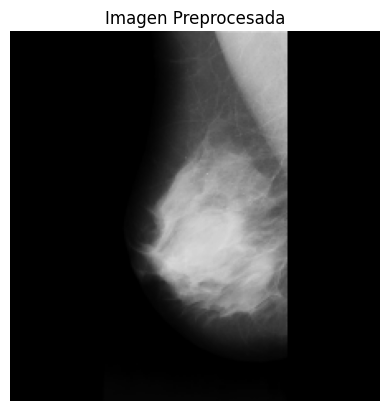

In [434]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
df= pd.read_csv("dataset_augmented.csv")
# Definimos el tamaño de entrada para EfficientNet B0
IMG_SIZE = (224, 224)

def load_and_preprocess_image(img_path):
    """Carga y preprocesa una imagen."""
    # Cargar imagen
    img = cv2.imread(img_path)
    # Redimensionar
    img = cv2.resize(img, IMG_SIZE)
    # Convertir a float32 y normalizar
    img = img.astype('float32') / 255.0
    return img

# Probamos la función de carga con una imagen
sample_img_path = df['ruta_imagen'].iloc[0]
sample_img = load_and_preprocess_image(sample_img_path)

plt.imshow(sample_img)
plt.title("Imagen Preprocesada")
plt.axis("off")
plt.show()

In [435]:
from sklearn.model_selection import train_test_split
# Definir las etiquetas utilizando las clases de interés
labels = df[['Class_ASYM', 'Class_CIRC', 'Class_MISC', 'Class_NORM']].values

# Carga todas las imágenes y sus respectivas etiquetas
images = np.array([load_and_preprocess_image(img_path) for img_path in df['ruta_imagen']])

print(f"Forma de images: {images.shape}")  # Debe ser (n_samples, 224, 224, 3)
print(f"Forma de labels: {labels.shape}")  # Debe ser (n_samples, 4)

# Definir las etiquetas one-hot
labels_one_hot = df[['Class_ASYM', 'Class_CIRC', 'Class_MISC', 'Class_NORM']].values

# Convertir las etiquetas one-hot a etiquetas enteras (1D) para la estratificación
labels_integer = np.argmax(labels_one_hot, axis=1)

# Carga todas las imágenes (asegúrate de que images_list no contenga None si alguna imagen falló en cargar)
images_list = []
valid_labels_one_hot = [] # Para mantener la correspondencia si alguna imagen no se carga
for i, img_path in enumerate(df['ruta_imagen']):
    img = load_and_preprocess_image(img_path) # Recuerda añadir cv2.cvtColor(img, cv2.COLOR_BGR2RGB) aquí
    if img is not None:
        images_list.append(img)
        valid_labels_one_hot.append(labels_one_hot[i]) # Solo añade la etiqueta si la imagen se cargó

images = np.array(images_list)
labels_one_hot = np.array(valid_labels_one_hot) # Actualiza labels_one_hot si hubo imágenes que no cargaron
labels_integer = np.argmax(labels_one_hot, axis=1) # Y recalcula labels_integer


print(f"Forma de images: {images.shape}")
print(f"Forma de labels_one_hot: {labels_one_hot.shape}")
print(f"Forma de labels_integer: {labels_integer.shape}")

# División en entrenamiento y prueba
X_train, X_test, y_train_oh, y_test_oh = train_test_split(
    images, labels_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=labels_integer 
)

X_train_final, X_val, y_train_final_oh, y_val_oh = train_test_split(
    X_train, y_train_oh,
    test_size=0.2,
    random_state=42,
    stratify=np.argmax(y_train_oh, axis=1) 
)

# Verificamos las formas de los conjuntos
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Forma de images: (927, 224, 224, 3)
Forma de labels: (927, 4)
Forma de images: (927, 224, 224, 3)
Forma de labels_one_hot: (927, 4)
Forma de labels_integer: (927,)
X_train shape: (741, 224, 224, 3), y_train shape: (741, 4)
X_test shape: (186, 224, 224, 3), y_test shape: (186, 4)


### Implementacion del modelo

In [436]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Número de clases (4 clases: ASYM, CIRC, MISC, NORM)
NUM_CLASSES = 4

# Cargar EfficientNet B0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Modelo secuencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # Capa oculta
    Dense(NUM_CLASSES, activation='softmax')  # Capa de salida con softmax
])

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuramos callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    X_train_final, y_train_final_oh,
    validation_data=(X_val, y_val_oh), # Pasas los datos de validación explícitamente
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2329 - loss: 1.2429

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.2330 - loss: 1.2403 - val_accuracy: 0.2416 - val_loss: 1.1863
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2606 - loss: 1.2078

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.2595 - loss: 1.2069 - val_accuracy: 0.2416 - val_loss: 1.1791
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2271 - loss: 1.2190

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.2267 - loss: 1.2177 - val_accuracy: 0.2349 - val_loss: 1.1715
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.2439 - loss: 1.1585 - val_accuracy: 0.2349 - val_loss: 1.1901
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.1884 - loss: 1.2054 - val_accuracy: 0.2416 - val_loss: 1.1927
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.2437 - loss: 1.2323 - val_accuracy: 0.2215 - val_loss: 1.2761
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.1838 - loss: 1.2161 - val_accuracy: 0.2416 - val_loss: 1.2889
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.2289 - loss: 1.1867 - val_accuracy: 0.2349 - val_loss: 1.1747


In [437]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

6/6 - 1s - 208ms/step - accuracy: 0.2258 - loss: 1.1848
Loss en test: 1.1848
Accuracy en test: 0.2258


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step


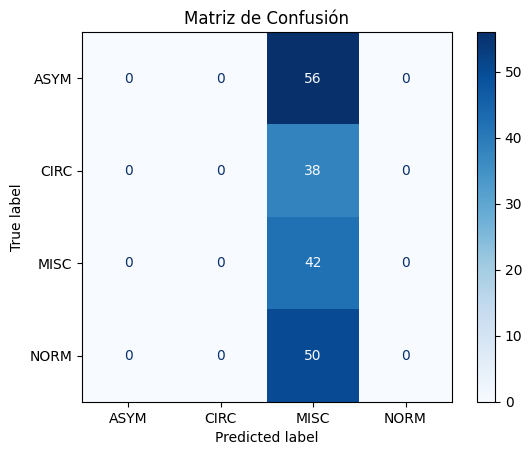

Reporte de clasificación:
              precision    recall  f1-score   support

        ASYM       0.00      0.00      0.00        56
        CIRC       0.00      0.00      0.00        38
        MISC       0.23      1.00      0.37        42
        NORM       0.00      0.00      0.00        50

    accuracy                           0.23       186
   macro avg       0.06      0.25      0.09       186
weighted avg       0.05      0.23      0.08       186



/Users/mafer/my_new_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mafer/my_new_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mafer/my_new_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [438]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1)       


class_names = ['ASYM', 'CIRC', 'MISC', 'NORM']


cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [439]:
import numpy as np
labels_argmax = np.argmax(labels, axis=1)
unique, counts = np.unique(labels_argmax, return_counts=True)
for class_name, count in zip(['ASYM', 'CIRC', 'MISC', 'NORM'], counts):
    print(f"{class_name}: {count} muestras")



ASYM: 282 muestras
CIRC: 224 muestras
MISC: 214 muestras
NORM: 207 muestras
